# Anomaly Detection in Public Spending

Anomaly detection in public spending recovered from Portal da Transparência.

<img src="img/anomalies_detected.jpg" align="center">

## Index
- [Imports](#Imports)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Feature Engeneering](#Feature-Engeneering)
- [Anomaly Detection](#Anomaly-Detection)
- [Shap Analisys](#Shap-Analisys)
- [Top 10](#Top-10)

### Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import shap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest

# %matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Reading configs and initalizing db
with open('.\configurations.yml') as file:
    configurations = yaml.load(file, Loader=yaml.FullLoader)
    
db = sqlite3.connect(configurations["Database"]["Path"]) # connecting to sqlite database

### Exploratory Data Analysis (EDA)

In [4]:
df = pd.read_sql_query("SELECT * FROM CARTOES", db)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62685 entries, 0 to 62684
Data columns (total 54 columns):
id                                 62685 non-null int64
mesExtrato                         62685 non-null object
dataTransacao                      62685 non-null object
valorTransacao                     62685 non-null float64
id_tipoCartao                      62685 non-null int64
codigo_tipoCartao                  62685 non-null object
descricao_tipoCartao               62685 non-null object
numeroInscricaoSocial              62685 non-null object
nome_estabelecimento               62685 non-null object
razaoSocialReceita                 62685 non-null object
nomeFantasiaReceita                62685 non-null object
localidadePessoa                   62685 non-null object
dataAbertura                       62685 non-null object
enderecoEletronico                 62685 non-null object
numeroTelefone                     62685 non-null object
descricaoLogradouro                62

In [6]:
df.head()

,id,mesExtrato,dataTransacao,valorTransacao,id_tipoCartao,codigo_tipoCartao,descricao_tipoCartao,numeroInscricaoSocial,nome_estabelecimento,razaoSocialReceita,...,nome_orgaoVinculado,codigoSIAFI,cnpj,sigla_orgaoVinculado,descricaoPoder,codigo_orgaoMaximo,sigla_orgaoMaximo,nome_orgaoMaximo,codigoFormatado_portador,nome_portador
0,151041007,10/2019,18/09/2019,9.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ZOOP TECNOLOGIA E MEIOS DE PAGAMENTO S.A.,ZOOP TECNOLOGIA E MEIOS DE PAGAMENTO S.A.,...,Instituto Federal Catarinense,26422,10635424000186,IFC,EXECUTIVO,26000,MEC,Ministério da Educação,***.857.959-**,HORALDO ANTONIO BRANDALISE
1,151041008,09/2019,02/08/2019,20.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,Sem informação,...,Ministério da Economia - Unidades com vínculo ...,25000,00394460000141,ME,EXECUTIVO,25000,ME,Ministério da Economia,***.646.795-**,JOAO VICTOR BARBOSA DE MATOS
2,151041009,04/2019,19/03/2019,609.38,1,1,Cartão de Pagamento do Governo Federal - CPGF,,M. L. COMERCIO E INDUSTRIA DE ALUMINIO LTDA,M. L. COMERCIO E INDUSTRIA DE ALUMINIO LTDA,...,Universidade Federal da Bahia,26232,15180714000104,UFBA,EXECUTIVO,26000,MEC,Ministério da Educação,***.483.205-**,ANTONIO CARLOS SAMPAIO AMARAL
3,151041010,08/2019,09/07/2019,389.60,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,Sem informação,...,Hospital de Clínicas de Porto Alegre,26294,87020517000120,HCPA,EXECUTIVO,26000,MEC,Ministério da Educação,***.877.890-**,ALROUCIAN SANTOS DA MOTTA
4,151041011,04/2019,13/03/2019,14.99,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ATACADO DA CONSTRUCAO LTDA,ATACADO DA CONSTRUCAO LTDA,...,Advocacia-Geral da União - Unidades com víncul...,63000,26994558000123,AGU,EXECUTIVO,63000,AGU,Advocacia-Geral da União,***.449.134-**,SENISE LIRA MONTENEGRO


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,62685.0,1.524251e+08,988691.686784,151041007.0,151593567.0,152094122.0,1.532000e+08,154293416.0
valorTransacao,62685.0,5.302797e+02,2346.239759,-27000.0,123.0,343.0,6.940300e+02,342000.0
id_tipoCartao,62685.0,1.465550e+00,0.537931,1.0,1.0,1.0,2.000000e+00,3.0


In [6]:
df["mesExtrato"].value_counts()

06/2018    7980
05/2018    7179
07/2018    6639
04/2018    5785
08/2019    3498
06/2019    3365
07/2019    3220
08/2018    2725
12/2018    2677
11/2018    2556
09/2018    2346
10/2018    2219
05/2019    2084
03/2018    1762
01/2019    1731
02/2018    1129
11/2019    1010
10/2019     950
12/2019     888
09/2019     872
01/2020     777
04/2019     602
03/2019     542
02/2019     149
Name: mesExtrato, dtype: int64

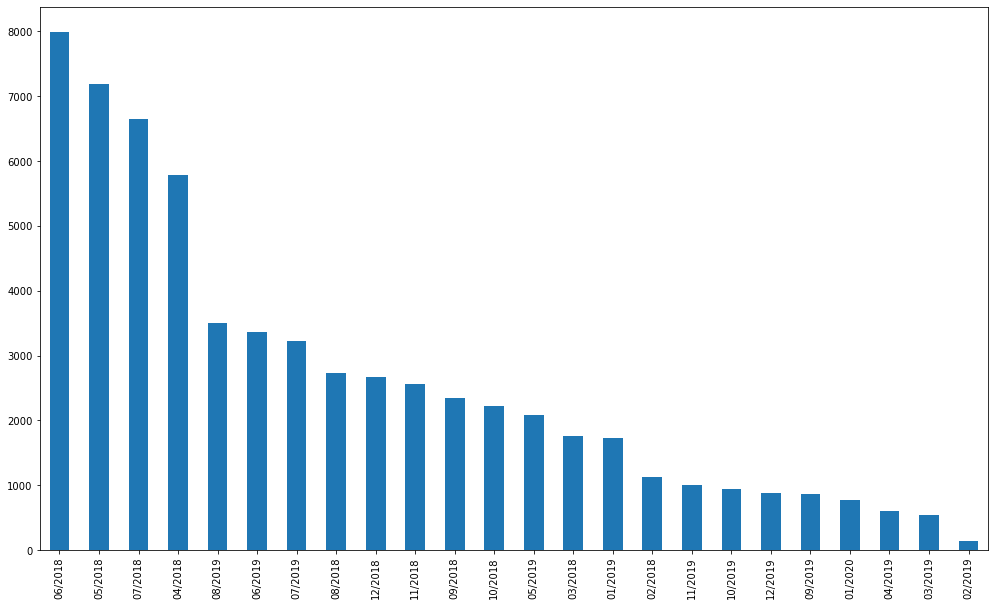

In [9]:
plt.figure(figsize=(17,10))
df["mesExtrato"].value_counts().plot(kind='bar')

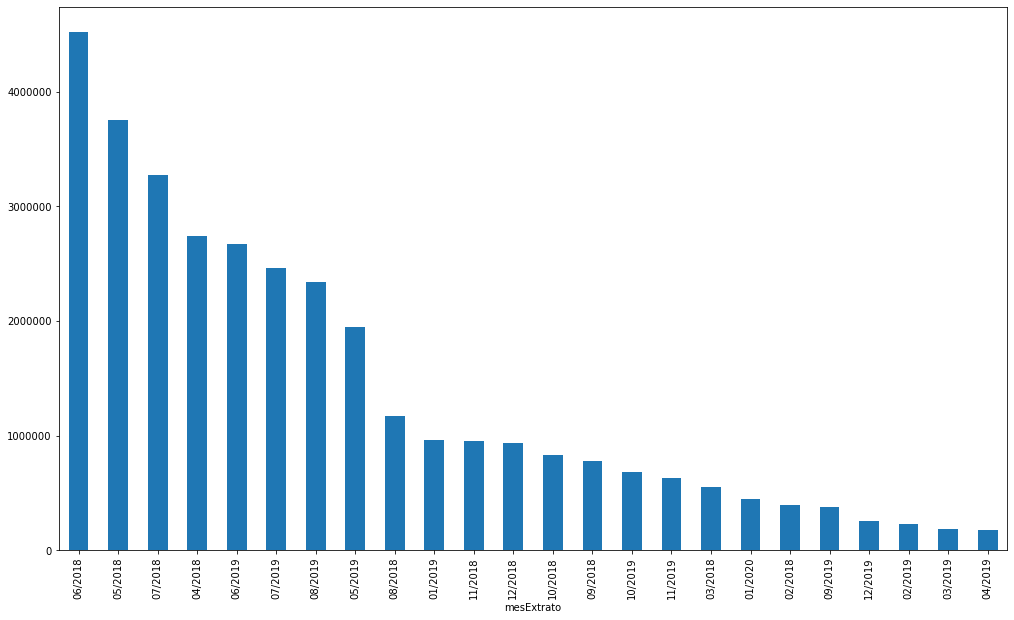

In [10]:
plt.figure(figsize=(17,10))
df.groupby(["mesExtrato"])["valorTransacao"].sum().sort_values(ascending =False).plot(kind="bar")

In [12]:
df.groupby(["nome_portador"])["valorTransacao"].value_counts().sort_values(ascending =False)

nome_portador               valorTransacao
RUI SOARES PALMEIRA          1000.00          847
NAO SE APLICA                154.45            58
RUI SOARES PALMEIRA         -1000.00           47
NAO SE APLICA                469.38            38
                             1113.36           37
                                             ... 
                             557.95             1
                             557.88             1
                             557.85             1
                             557.51             1
ABELARDO FLORIANO DE PAULO   65.00              1
Name: valorTransacao, Length: 45993, dtype: int64

In [13]:
df.groupby(["nome_portador"])["valorTransacao"].sum().sort_values(ascending =False)

nome_portador
NAO SE APLICA                      19229966.63
AURISONIA RODRIGUES TELES DODTH      870349.06
RUI SOARES PALMEIRA                  801500.00
ELIZEU LISBOA DANTAS                 464473.49
JOSE DA SILVA LIMA                   423400.00
                                      ...     
MOISES PEREIRA DE MELO                -3078.39
JOSE CARNEIRO ALMEIDA DA SILVA       -18000.00
SILVANA FERNANDES MARINHO            -27000.00
MARINEIDIA DA SILVA PEREIRA          -36000.00
JOSE MANGUEIRA TORRES                -54000.00
Name: valorTransacao, Length: 5408, dtype: float64

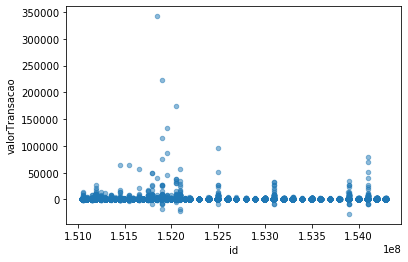

In [14]:
df.plot.scatter("id", "valorTransacao", alpha=0.5)

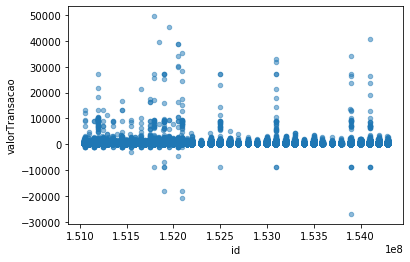

In [15]:
df[df.valorTransacao < 50000].plot.scatter("id", "valorTransacao", alpha=0.5)

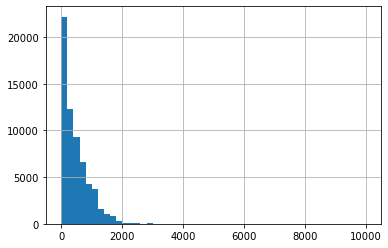

In [16]:
df.valorTransacao.hist(range=(0, 10000), bins=50)

In [17]:
df.valorTransacao.sort_values()

55677    -27000.00
32049    -20940.56
32067    -18000.00
28795    -18000.00
55672     -9000.00
           ...    
28805    113921.77
15879    132799.32
17500    173791.56
28815    223394.65
14156    342000.00
Name: valorTransacao, Length: 62685, dtype: float64

In [18]:
df.valorTransacao.sort_values(ascending=False)

14156    342000.00
28815    223394.65
17500    173791.56
15879    132799.32
28805    113921.77
           ...    
55672     -9000.00
28795    -18000.00
32067    -18000.00
32049    -20940.56
55677    -27000.00
Name: valorTransacao, Length: 62685, dtype: float64

In [19]:
len(df[df.valorTransacao <= 0])

67

In [21]:
df1 = df.groupby('nome_portador').agg({'valorTransacao':'sum'})
df1 = df1.reset_index()
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
valorTransacao,5408.0,6146.55721,262238.484884,-54000.0,337.405,862.74,2009.085,19229966.63


In [22]:
df1_maior_200k = df1[df1['valorTransacao'] >= 200000]
df1_maior_200k.head()

,nome_portador,valorTransacao
258,ALISSON CESAR MONTEIRO,319255.02
655,AURISONIA RODRIGUES TELES DODTH,870349.06
1080,CLEYTON BASTOS BEZERRA,201421.72
1564,ELIZEU LISBOA DANTAS,464473.49
2780,JOSE DA SILVA LIMA,423400.00


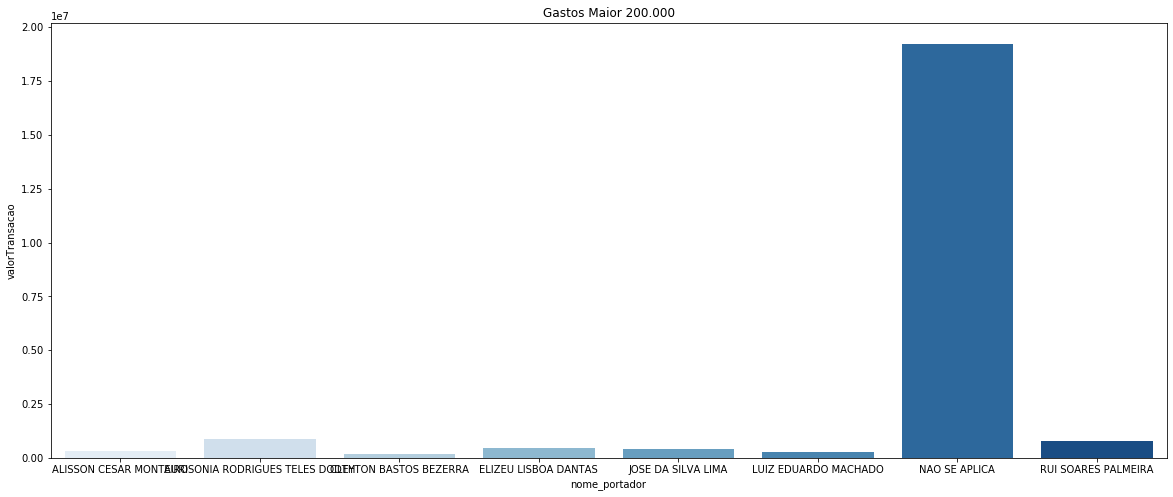

In [26]:
plt.figure(figsize=(20,8))
plt.title("Gastos Maior 200.000")
sns.barplot(x="nome_portador", y="valorTransacao", data=df1_maior_200k, palette='Blues');

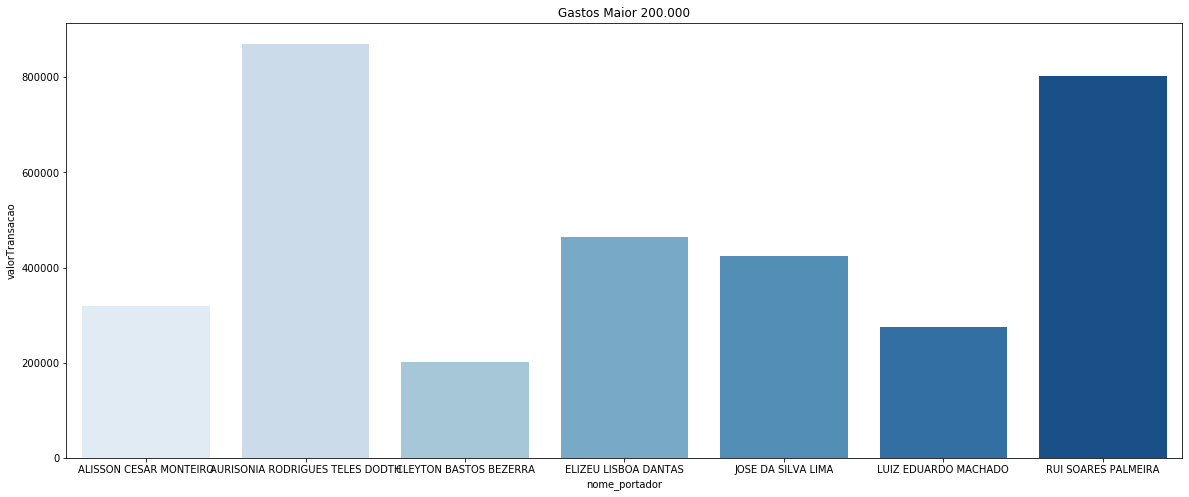

In [27]:
plt.figure(figsize=(20,8))
plt.title("Gastos Maior 200.000")
sns.barplot(x="nome_portador", y="valorTransacao", data=df1_maior_200k[df1_maior_200k.nome_portador != "NAO SE APLICA"], palette='Blues');

In [33]:
df_rui = df[(df.nome_portador == "RUI SOARES PALMEIRA") & (df.codigoFormatado_portador == "***.483.964-**")]
df_rui.head()

,id,mesExtrato,dataTransacao,valorTransacao,id_tipoCartao,codigo_tipoCartao,descricao_tipoCartao,numeroInscricaoSocial,nome_estabelecimento,razaoSocialReceita,...,nome_orgaoVinculado,codigoSIAFI,cnpj,sigla_orgaoVinculado,descricaoPoder,codigo_orgaoMaximo,sigla_orgaoMaximo,nome_orgaoMaximo,codigoFormatado_portador,nome_portador
1562,151051521,09/2019,09/08/2019,1000.0,3,3,Cartão de Pagamento da Defesa Civil - CPDC,,MARIA ZOEL ROCHA DOS SANTOS,,...,Ministério do Desenvolvimento Regional - Unida...,53000,03353358000196,INTEGRAÇÃO,EXECUTIVO,53000,INTEGRAÇÃO,Ministério do Desenvolvimento Regional,***.483.964-**,RUI SOARES PALMEIRA
1563,151051522,10/2019,23/09/2019,1000.0,3,3,Cartão de Pagamento da Defesa Civil - CPDC,,CAMILO RODRIGUES CAMARA,,...,Ministério do Desenvolvimento Regional - Unida...,53000,03353358000196,INTEGRAÇÃO,EXECUTIVO,53000,INTEGRAÇÃO,Ministério do Desenvolvimento Regional,***.483.964-**,RUI SOARES PALMEIRA
1564,151051523,10/2019,09/09/2019,1000.0,3,3,Cartão de Pagamento da Defesa Civil - CPDC,,MARIGLIBSON CORREIA DE LIMA,,...,Ministério do Desenvolvimento Regional - Unida...,53000,03353358000196,INTEGRAÇÃO,EXECUTIVO,53000,INTEGRAÇÃO,Ministério do Desenvolvimento Regional,***.483.964-**,RUI SOARES PALMEIRA
1565,151051524,10/2019,06/09/2019,-1000.0,3,3,Cartão de Pagamento da Defesa Civil - CPDC,,SILVANIA MARIA DO NASCIMENTO,,...,Ministério do Desenvolvimento Regional - Unida...,53000,03353358000196,INTEGRAÇÃO,EXECUTIVO,53000,INTEGRAÇÃO,Ministério do Desenvolvimento Regional,***.483.964-**,RUI SOARES PALMEIRA
1566,151051525,11/2019,17/10/2019,1000.0,3,3,Cartão de Pagamento da Defesa Civil - CPDC,,UMBERTO DA COSTA PASSOS NETO,,...,Ministério do Desenvolvimento Regional - Unida...,53000,03353358000196,INTEGRAÇÃO,EXECUTIVO,53000,INTEGRAÇÃO,Ministério do Desenvolvimento Regional,***.483.964-**,RUI SOARES PALMEIRA


In [34]:
df_rui.valorTransacao.value_counts()

 1000.0    847
-1000.0     47
 500.0       3
Name: valorTransacao, dtype: int64

### Feature Engeneering

- Número de Gastos no (Último mês/Semestre/...)
- Quantidade de Gastos com valores iguais (Último mês/Semestre...)
- Transações de mesma categoria no mesmo dia (Capturando similaridades)
- Horários próximos de transações similares
- 

In [54]:
# Querying database with used columns

df = pd.read_sql_query('''SELECT 
  id,
  valorTransacao,
  dataTransacao,
  codigoSubclasse,
  tipoCodigo,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_portador ORDER BY dataTransacao ASC) 								AS valorTransacao_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_portador ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, codigo_unidadeGestora ORDER BY dataTransacao ASC) 						AS valorTransacao_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, codigo_unidadeGestora ORDER BY dataTransacao ASC) 	AS codigoFormatado_estabelecimento_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_orgaoMaximo ORDER BY dataTransacao ASC) 							AS valorTransacao_count_byDepartment,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_orgaoMaximo ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_bydepartment  
FROM cartoes 
WHERE valorTransacao||nome_estabelecimento||nome_portador not in (SELECT -valorTransacao||nome_estabelecimento||nome_portador from cartoes where valorTransacao <0)
and valorTransacao > 0''', db)

In [55]:
# Setting datetime columns

df['dataTransacao'] = pd.to_datetime(df['dataTransacao'])
df['diaSemana'] = df['dataTransacao'].dt.dayofweek
df['dia'] = df['dataTransacao'].dt.day
df['mes'] = df['dataTransacao'].dt.month
df['ano'] = df['dataTransacao'].dt.year

In [56]:
# Manipulating cat and enum classes

df.codigoSubclasse = df.codigoSubclasse.map(int)
df.tipoCodigo = df.tipoCodigo.apply(lambda x: 1 if x=='CNPJ' else 0)

### Anomaly Detection

In [57]:
# Initating Isolation Forest

model = IsolationForest(random_state=42)
df['result'] = model.fit_predict(df.drop(labels=['id','dataTransacao'],axis=1))
df['score'] = -model.score_samples(df.drop(labels=['id','dataTransacao','result'],axis=1))

In [58]:
# Counting Outliers Percentage

df.result.value_counts(normalize=True)

 1    0.873001
-1    0.126999
Name: result, dtype: float64

In [44]:
# Saving Results on Database

df[['id','score','result']].to_sql(name='results', con=db, if_exists='replace', index=False)

___

### Shap Analisys

<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" align="center">

In [14]:
#!pip3 install shap

In [9]:
shap.initjs() # Need to load JS vis in the notebook

In [10]:
explainer = shap.TreeExplainer(model) # settings model
observations = df.drop(columns=['id', 'dataTransacao', 'result', 'score']).sample(1000).to_numpy() # setting dataframe sample
all_features = list(df.drop(columns=['id', 'dataTransacao', 'result', 'score']).columns) # setting columns names
shap_values = explainer.shap_values(observations) # In order to compute the shapley values with the tree explainer, we need to call the shap_values methods passing a dataset.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [11]:
all_features

['valorTransacao',
 'codigoSubclasse',
 'tipoCodigo',
 'valorTransacao_count_byPerson',
 'codigoFormatado_estabelecimento_count_byPerson',
 'valorTransacao_count_byAgency',
 'codigoFormatado_estabelecimento_count_byAgency',
 'valorTransacao_count_byDepartment',
 'codigoFormatado_estabelecimento_count_bydepartment',
 'diaSemana',
 'dia',
 'mes',
 'ano']

In [12]:
all_features = ['valTrans', 'codSubclasse', 'tipoCod', 'valRepetidoPessoa', 'codEstabPessoa', 'valTransAg', 'codEstabAg', 'valTransDept', 'codEstabDept', 'DOW', 'dia', 'mes', 'ano']

In [13]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

In [15]:
shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

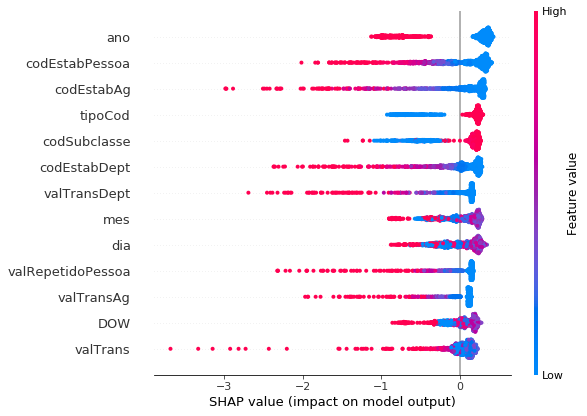

In [16]:
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

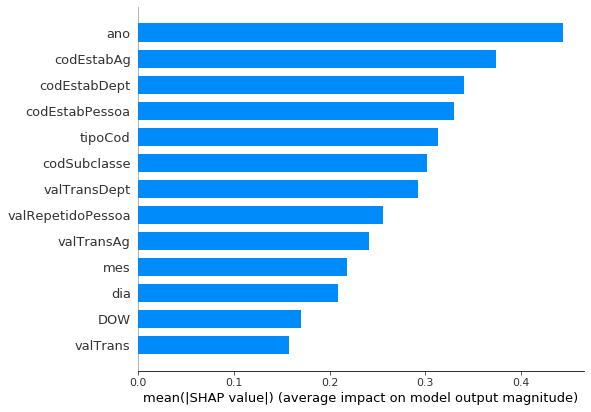

In [104]:
shap.summary_plot(shap_values, shap_values, plot_type='bar', feature_names=all_features)

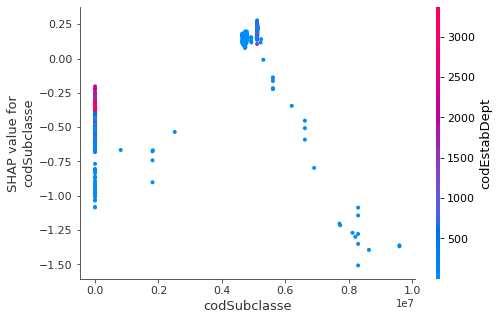

In [108]:
shap.dependence_plot(1, shap_values,
                features=observations, feature_names=all_features)

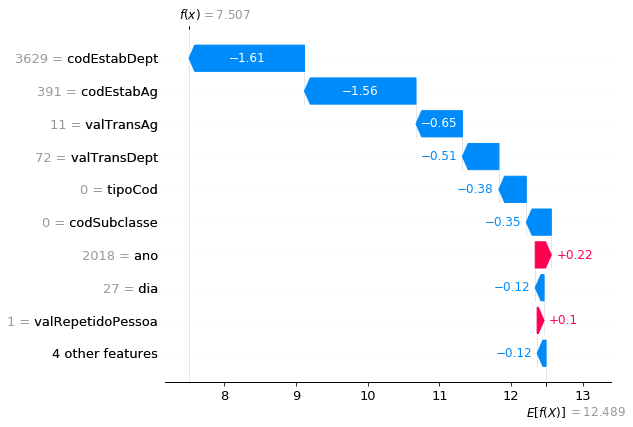

In [110]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[0],
                features=observations[0], feature_names=all_features)

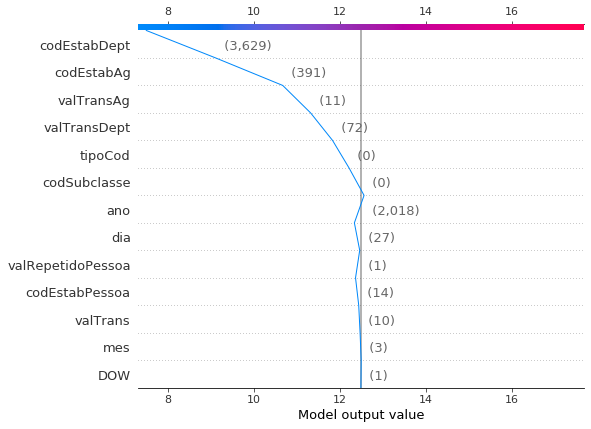

In [111]:
shap.decision_plot(explainer.expected_value, shap_values[0], 
                features=observations[0], feature_names=all_features)

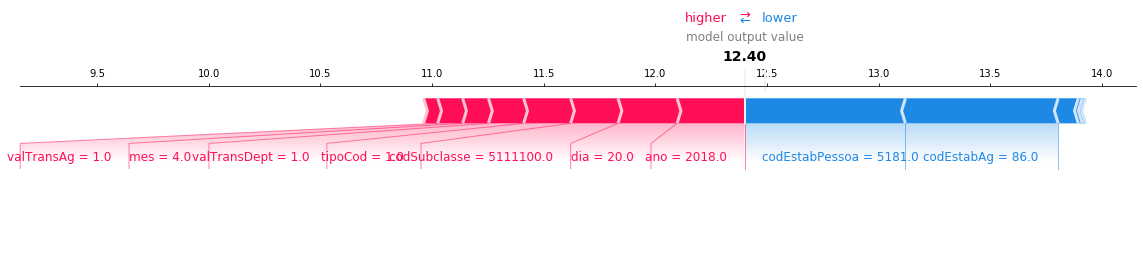

In [42]:
# SAVE SHAP PLOT .PNG
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features, show=False, matplotlib=True).savefig('explainer.png')

In [41]:
# SAVE PLOT AS HTML

shap.save_html('explainer.html', shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features))

In [19]:
#EXPORT TREE IMAGE

estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = all_features,
                class_names = ['normal', 'anomaly'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

0

In [20]:
!dot -Tpdf tree.dot -o tree.pdf

____

### Top 10

In [45]:
df.sort_values(by="score", ascending=False).head()

,id,valorTransacao,dataTransacao,codigoSubclasse,tipoCodigo,valorTransacao_count_byPerson,codigoFormatado_estabelecimento_count_byPerson,valorTransacao_count_byAgency,codigoFormatado_estabelecimento_count_byAgency,valorTransacao_count_byDepartment,codigoFormatado_estabelecimento_count_bydepartment,diaSemana,dia,mes,ano,result,score
55872,151747640,1000.0,2019-12-23,0,0,734,3,736,3,736,3,0,23,12,2019,-1,0.726144
55944,151148866,1000.0,2019-01-30,0,0,806,2,808,2,809,2,2,30,1,2019,-1,0.726128
55943,152047889,1000.0,2019-01-30,0,0,805,2,807,2,808,2,2,30,1,2019,-1,0.726128
55940,151352379,1000.0,2019-01-30,0,0,802,2,804,2,805,2,2,30,1,2019,-1,0.726128
55941,151051575,1000.0,2019-01-30,0,0,803,2,805,2,806,2,2,30,1,2019,-1,0.726128


In [10]:
# Grouping By 
anomaly = df[df.result == -1]
full = pd.read_sql_query("SELECT * FROM CARTOES", db)
anomaly = anomaly.drop(columns=["valorTransacao", "dataTransacao", "codigoSubclasse", "tipoCodigo"]).merge(full, how="inner", on="id")
anomaly.head()

,id,valorTransacao_count_byPerson,codigoFormatado_estabelecimento_count_byPerson,valorTransacao_count_byAgency,codigoFormatado_estabelecimento_count_byAgency,valorTransacao_count_byDepartment,codigoFormatado_estabelecimento_count_bydepartment,diaSemana,dia,mes,...,nome_orgaoVinculado,codigoSIAFI,cnpj,sigla_orgaoVinculado,descricaoPoder,codigo_orgaoMaximo,sigla_orgaoMaximo,nome_orgaoMaximo,codigoFormatado_portador,nome_portador
0,153991060,1,5,3,249,3,4125,0,30,4,...,Fundação Instituto Brasileiro de Geografia e E...,25205,33787094000140,IBGE,EXECUTIVO,25000,ME,Ministério da Economia,***.369.131-**,RUBENS RODRIGUES DE CARVALHO JUNIOR
1,151541104,1,1,1,1,1,74,5,2,11,...,Companhia de Pesquisa de Recursos Minerais,29208,00091652000189,CPRM,EXECUTIVO,32000,MME,Ministério de Minas e Energia,***.168.097-**,NATHALIA WINKELMANN ROITBERG
2,151738096,1,5,1,38,10,3292,0,25,3,...,Fundação Instituto Brasileiro de Geografia e E...,25205,33787094000140,IBGE,EXECUTIVO,25000,ME,Ministério da Economia,***.612.365-**,CARLA JULIANA SANTOS ALENCAR
3,153191712,1,4,2,177,8,2603,4,20,4,...,Fundação Instituto Brasileiro de Geografia e E...,25205,33787094000140,IBGE,EXECUTIVO,25000,ME,Ministério da Economia,***.751.519-**,MARCOS ROBERTO LEITE
4,151991742,1,3,1,119,12,3684,4,27,7,...,Fundação Instituto Brasileiro de Geografia e E...,25205,33787094000140,IBGE,EXECUTIVO,25000,ME,Ministério da Economia,***.515.793-**,RAIMUNDO FLAVIO SOARES


In [12]:
# Top 10 Atual
anomaly.groupby(['nome_portador', 'codigoFormatado_portador']).result.value_counts().sort_values(ascending=False)[:11]

nome_portador                              codigoFormatado_portador  result
NAO SE APLICA                              -2                        -1        2474
RUI SOARES PALMEIRA                        ***.483.964-**            -1         830
AURISONIA RODRIGUES TELES DODTH            ***.519.993-**            -1         104
PAULO SERGIO FERRARI                       ***.551.588-**            -1          39
FLAVIO ANTONIO FREIRE DA ROSA              ***.365.430-**            -1          28
JOSE ROBERVAL CALHEIROS GONZAGA            ***.482.712-**            -1          26
DIVONEI ROSENILSON DA SILVA                ***.634.359-**            -1          23
WELLINGTON DENIS COSTA PEREIRA             ***.980.402-**            -1          23
PAULA MARQUES MEYER                        ***.820.648-**            -1          23
ALESSANDRO FRANCISCO TRINDADE DE OLIVEIRA  ***.206.179-**            -1          22
JOSE WEYNE NUNES MARCELINO                 ***.375.573-**            -1          22


In [8]:
suspects = pd.read_sql_query("SELECT * FROM SUSPECT", db)

In [9]:
suspects.head(10)

,ID,NOME,CPF,PODER,ORGAO_MAXIMO,ORGAO_VINCULADO,UNIDADE_GESTORA,CARGO,ESTADO_NASCIMENTO,IMAGEM
0,1,RUI SOARES PALMEIRA,***.483.964-**,EXECUTIVO,Ministério do Desenvolvimento Regional,Ministério do Desenvolvimento Regional - Unida...,SECRETARIA NACIONAL DE DEFESA CIVIL - SEDEC,67º Prefeito de Maceió,"Maceió, AL, Brasil",/static/img/politicians/RUI_SOARES_PALMEIRA.jpg
1,2,AURISONIA RODRIGUES TELES DODTH,***.519.993-**,EXECUTIVO,Ministério do Desenvolvimento Regional,Ministério do Desenvolvimento Regional - Unida...,SECRETARIA NACIONAL DE DEFESA CIVIL - SEDEC,Diretor Administrativo Financeiro,TERESINA - PI,None
2,3,PAULO SERGIO FERRARI,***.551.588-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE EM SAO PAULO,,Paraná,None
3,4,FLAVIO ANTONIO FREIRE DA ROSA,***.365.430-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE NO RIO GRANDE DO SUL,,São Paulo,None
4,5,JOSE ROBERVAL CALHEIROS GONZAGA,***.482.712-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE NO AMAZONAS,Técnico no Instituto Brasileiro de Geografia,MANACAPURU - AM,None
5,6,DIVONEI ROSENILSON DA SILVA,***.634.359-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE NO PARANA,,São Paulo,None
6,7,WELLINGTON DENIS COSTA PEREIRA,***.980.402-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE NO PARA,,,None
7,8,PAULA MARQUES MEYER,***.820.648-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE EM SAO PAULO,Supervisão de Estatísticas Agropecuárias,São Paulo,/static/img/politicians/PAULA_MARQUES_MEYER.jpg
8,9,ALESSANDRO FRANCISCO TRINDADE DE OLIVEIRA,***.206.179-**,EXECUTIVO,Ministério da Economia,Fundação Instituto Brasileiro de Geografia e E...,UNIDADE ESTADUAL DO IBGE NO PARANA,IBGE,"Paraná, PR",None
9,10,JOSE WEYNE NUNES MARCELINO,***.375.573-**,EXECUTIVO,Ministério da Economia,Ministério da Economia - Unidades com vínculo ...,SECRETARIA DE INSPEÇÃO DO TRABALHO - SIT,Cargo/emprego efetivo do Poder Executivo Federal,FLORIANÓPOLIS - SC,/static/img/politicians/JOSE_WEYNE_NUNES_MARCE...


___

In [59]:
# Generate top10 spending shaps

# Getting all top10 spending from top10 suspects
for i in range(1, 11):
    try:
        df_ = pd.concat([pd.read_sql_query(F"SELECT * FROM SPENDING WHERE SUSPECT_ID = {i} AND RESULTADO = 1 ORDER BY PROBABILIDADE DESC LIMIT 10", db), df_])
        df_ = pd.concat([pd.read_sql_query(F"SELECT * FROM SPENDING WHERE SUSPECT_ID = {i} AND RESULTADO = -1 ORDER BY PROBABILIDADE DESC LIMIT 10", db), df_])
    except:
        df_ = pd.read_sql_query(F"SELECT * FROM SPENDING WHERE SUSPECT_ID = {i} AND RESULTADO = 1 ORDER BY PROBABILIDADE DESC LIMIT 10", db)
        df_ = pd.concat([pd.read_sql_query(F"SELECT * FROM SPENDING WHERE SUSPECT_ID = {i} AND RESULTADO = -1 ORDER BY PROBABILIDADE DESC LIMIT 10", db), df_])
        
# selecting Spendings Ids
ids = list(df_.SPENDING_ID.values.astype(int))

# Creating 2 df with top10 spendings and all others
df_ = df[df.id.isin(ids)]
df = df[df.id.isin(ids) == False]

# creating a new df with all top10 spendings and +1000 samples for shapping analisys
ids = list(final.iloc[0 : 165, :].id.values.astype(int)) # updating ids order
final = pd.concat([df_, df.sample(1000)]).reset_index()

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [81]:
# Creating SHAP analisys
explainer = shap.TreeExplainer(model) # settings model
observations = final.drop(columns=['id', 'dataTransacao', 'result', 'score']).to_numpy() # setting dataframe sample
shap_values = explainer.shap_values(observations) # In order to compute the shapley values with the tree explainer, we need to call the shap_values methods passing a dataset.
all_features = ['valTrans', 'codSubclasse', 'tipoCod', 'valRepetidoPessoa', 'codEstabPessoa', 'valTransAg', 'codEstabAg', 'valTransDept', 'codEstabDept', 'DOW', 'dia', 'mes', 'ano']

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [101]:
# Generating SHAP Force Plot HTML results
for i in range(len(ids)):
    shap.save_html(F'./app/templates/shap/{ids[i]}_shap.html', shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features))